In [14]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost

# Core
import numpy as np
import scipy.io as io
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from mlens.ensemble import SuperLearner

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder
from onecyclelr import OneCycleLR
import pcgrad

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
DATA_PATH = "/Users/pongpisit/Desktop/research/pinn/Solving-Differential-Equations-with-Neural-Networks/SymbolicMathematics/data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 2000
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Convert to torch.tensor
X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)
X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)

feature_names=['uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx']

Training with 2000 samples


In [4]:
class Network(nn.Module):
    def __init__(self, model):
        super(Network, self).__init__()
        self.model = model
#         self.model.apply(self.xavier_init)
        # For tracking
        self.index2features = ('uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx')
        self.uf = None
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        self.uf = self.model(torch.cat([x, t], dim=1))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        
        ### PDE Loss calculation ###
        # first-order derivatives
        u_t = self.gradients(uf, t)[0]
        u_x = self.gradients(uf, x)[0]
        # Homo second-order derivatives
        u_tt = self.gradients(u_t,t)[0]
        u_xx = self.gradients(u_x, x)[0]
        # Hetero second-order derivatives
        u_xt = self.gradients(u_t, x)[0]
        u_tx = self.gradients(u_x, t)[0]
        
        X_selector = torch.cat([uf, u_x, u_xx, u_tt, u_xt, u_tx], dim=1)
        y_selector = u_t
        
        return X_selector, y_selector
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

In [5]:
# Does the SeclectorNetwork has to be a neural networks ???
class SeclectorNetwork(nn.Module):
    def __init__(self, X_train_dim, bn=None):
        super().__init__()
        # Nonlinear model, Training with PDE reg.
        self.nonlinear_model = TorchMLP(dimensions=[X_train_dim, 50, 50, 1], bn=bn)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        ut_approx = self.nonlinear_model(inn)
        return ut_approx
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss

class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
    def forward(self, X_u_train):
        inn = X_u_train
        if self.normalize_derivative_features:
            inn = minmax_normalize(inn)
        unsup_loss = self.selector.loss(*self.network.get_selector_data(*dimension_slicing(inn)))
        return self.network.uf, unsup_loss

In [6]:
# network = Network(model=TorchMLP(dimensions=[6, 50, 50, 50 ,50, 50, 1], bn=nn.BatchNorm1d))
# selector = SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm)
semisup_model = SemiSupModel(network=Network(model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], bn=nn.LayerNorm)),
                             selector=SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm),
                             normalize_derivative_features=False)

In [6]:
def pcgrad_closure():
    uf, unsup_loss = semisup_model(X_u_train)
    losses = [F.mse_loss(uf, u_train), unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    return sum(losses)

def closure():
    optimizer2.zero_grad()
    mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train)), u_train)
    mse_loss.backward(retain_graph=True)
    return mse_loss

Learning rate finding


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.14E-07


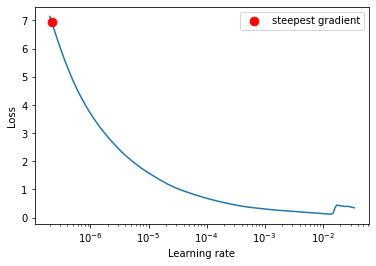

In [7]:
params = semisup_model.parameters()

### For SGD and Adam ###
learning_rate1, learning_rate2 = 1e-8, 1e-1

### For LBFGS (a good choice already!!!) ###
# print("Using LBFGS's learning rate set")
# learning_rate1, learning_rate2 = 8e-2, 5e-2 # (1e-1, 5e-2) is also OK!

choice = 'SGD'; auto_lr = True
if choice == 'LBFGS':
    optimizer1 = torch.optim.LBFGS(params, lr=learning_rate1, 
                                   max_iter=100, max_eval=125, 
                                  history_size=120, line_search_fn='strong_wolfe')
if choice == 'Adam':
    optimizer1 = AdamGC(params, lr=learning_rate1, use_gc=True, gc_conv_only=False, gc_loc=False)
if choice == 'SGD':
    optimizer1 = SGDGC(params, lr=learning_rate1, use_gc=True, nesterov=True, momentum=0.95)

if choice != 'LBFGS' and auto_lr:
    print('Learning rate finding')
    bs = 4000; bs = X_u_train.shape[0] if bs>X_u_train.shape[0] else bs
    criterion = LadderLoss(return_list=True)
    trainloader = get_dataloader(X_u_train, u_train, bs=bs)
    
    lr_finder = LRFinder(semisup_model, optimizer=optimizer1, 
                         closure=pcgrad_update, criterion=criterion, device="cpu")
    lr_finder.range_test(trainloader, val_loader=None, end_lr=100, num_iter=300)
    
    # to inspect the loss-learning rate graph
    suggested_lr, _ = lr_finder.plot()
    # To prevent divergence during the second stage training.
    # suggested_lr = min(suggested_lr, 5e-3)
    lr_finder.reset(); plt.show()

In [8]:
# Set the learing_rate to the suggested one.
# suggested_lr = float(input())
optimizer1 = lr_finder.optimizer
for g in optimizer1.param_groups:
    g['lr'] = suggested_lr
epochs1 = 2000; epochs2 = 500;

In [9]:
semisup_model.train()
curr_loss = 1000; F_print = 10 if choice == 'LBFGS' else 100

# Stage I
for i in range(epochs1):
    optimizer1.step(pcgrad_closure)
    l = pcgrad_closure()
    if (i % F_print) == 0:
        if l.item() != curr_loss:
            curr_loss = l.item()
        else:
            print("Epoch {}: ".format(i), curr_loss)
            print("Finishing the first stage")
            break
        print("Epoch {}: ".format(i), curr_loss)

Epoch 0:  7.372777938842773
Epoch 100:  1.5587310791015625
Epoch 200:  1.2774720191955566
Epoch 300:  1.124897837638855
Epoch 400:  1.016829252243042
Epoch 500:  0.9325682520866394
Epoch 600:  0.8625723123550415
Epoch 700:  0.8020140528678894
Epoch 800:  0.7486374974250793
Epoch 900:  0.7019697427749634
Epoch 1000:  0.6566792726516724
Epoch 1100:  0.6192731857299805
Epoch 1200:  0.5833610892295837
Epoch 1300:  0.5476791858673096
Epoch 1400:  0.5196598768234253
Epoch 1500:  0.4956129193305969
Epoch 1600:  0.4755100905895233
Epoch 1700:  0.4580637812614441
Epoch 1800:  0.4452587366104126
Epoch 1900:  0.43433934450149536


In [10]:
optimizer2 = torch.optim.LBFGS(semisup_model.network.parameters(), 
                              lr=learning_rate2, max_iter=100, max_eval=125, 
                              history_size=120, line_search_fn='strong_wolfe')

curr_loss = 1000
# Stage II
for i in range(epochs2):
    optimizer2.step(closure)
    l = closure()
    if (i % 10) == 0:
        if l.item() != curr_loss:
            curr_loss = l.item()
        else:
            print("Finishing the second stage")
            break
        print("Epoch {}: ".format(i), curr_loss)

print("Testing")
semisup_model.network.eval()
# should be able to reach the order of 1e-6.
# So that I can use this algo instead of the ladder networks
# Compare btw the two semi-supervise learning?
print('Test MSE:', F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item())

Epoch 0:  0.0003895397821906954
Epoch 10:  1.300813210036722e-06
Epoch 20:  7.559316941296856e-07
Epoch 30:  6.600974415960081e-07
Epoch 40:  5.95641438394523e-07
Epoch 50:  5.210356448515086e-07
Epoch 60:  5.126315159031947e-07
Epoch 70:  4.765784069604706e-07
Epoch 80:  4.392971959532588e-07
Epoch 90:  4.133203219680581e-07
Epoch 100:  3.981241434303229e-07
Epoch 110:  3.959651735385705e-07
Finishing the second stage
Testing
Test MSE: 2.2498645648738602e-06


In [13]:
# BEST-2000: 1e-06 (LBFGS)
# torch.save(semisup_model.state_dict(), "./saved_path_inverse_burger/semisup_model_with_LayerNorm_without_physical_reg_trained2000samples.pth")

In [9]:
# Loading the best model and testing
semisup_model.load_state_dict(torch.load("./saved_path_inverse_burger/semisup_model_with_LayerNorm_without_physical_reg_trained2000samples.pth"))
semisup_model.eval()
F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star)

tensor(2.2499e-06, grad_fn=<MseLossBackward>)

In [18]:
# derivatives_test, dynamics_test = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
# derivatives_train, dynamics_train = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))

# derivatives_test, dynamics_test = to_numpy(derivatives_test), to_numpy(dynamics_test)
# derivatives_train, dynamics_train = to_numpy(derivatives_train), to_numpy(dynamics_train)

# np.save("./saved_path_inverse_burger/data/derivatives-2000-V3.npy", derivatives_train)
# np.save("./saved_path_inverse_burger/data/dynamics-2000-V3.npy", dynamics_train)
# np.save("./saved_path_inverse_burger/data/derivatives-25600-V3.npy", derivatives_test)
# np.save("./saved_path_inverse_burger/data/dynamics-25600-V3.npy", dynamics_test)